In [0]:
!git clone -b dev https://github.com/nyikovicsmate/thesis

Cloning into 'thesis'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 1556 (delta 93), reused 105 (delta 69), pack-reused 1419
Receiving objects: 100% (1556/1556), 163.35 MiB | 11.18 MiB/s, done.
Resolving deltas: 100% (582/582), done.


In [0]:
%cd thesis

/content/thesis


In [0]:
!pip3 install -q gdown
# bsd500_gray.zip
!gdown https://drive.google.com/uc?id=1O2tduoLX1DdP3VoLkAQfuv5ssFxf8LPc
!unzip -q bsd500_gray.zip
# # bsd500_color.zip
!gdown https://drive.google.com/uc?id=1buG1ziqMjy18gnpkuQjqk81XrLsGjT7p
!unzip -q bsd500_color.zip
# # set14_color.zip
!gdown https://drive.google.com/uc?id=1OiDs7jRm3NZCY6ghjyE12G5hVS0fG4EM
!unzip -q set14_color.zip

Downloading...
From: https://drive.google.com/uc?id=1O2tduoLX1DdP3VoLkAQfuv5ssFxf8LPc
To: /content/thesis/bsd500_gray.zip
11.3MB [00:00, 19.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1buG1ziqMjy18gnpkuQjqk81XrLsGjT7p
To: /content/thesis/bsd500_color.zip
29.4MB [00:01, 27.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OiDs7jRm3NZCY6ghjyE12G5hVS0fG4EM
To: /content/thesis/set14_color.zip
100% 831k/831k [00:00<00:00, 55.4MB/s]


In [0]:
%tensorflow_version 2.x
from src.networks.supervised.progressive_upsampling_network import ProgressiveUpsamplingNetwork
from src.callbacks import *
from src.dataset import *
import numpy as np
import tensorflow as tf

In [0]:
batch_size = 20
seed = 1111
epochs = 2000
learning_rate = 1e-4

normalize = lambda x: np.asarray(x / 255.0, dtype=np.float32)
downsample = lambda x: np.array([cv2.resize(x_i, (x.shape[2]//2, x.shape[1]//2), interpolation=cv2.INTER_CUBIC) for x_i in x])

ds = HDFDataset("bsd500_140_140_color.h5").batch(batch_size).shuffle(seed).transform()
ds_hr_1 = ds.map(normalize)
ds_hr_0 = ds.map(downsample).map(normalize)
ds_lr = ds.map(downsample).map(downsample).map(normalize)

input_shape = (None, None, 3)
loss_func = tf.keras.losses.mse
cb = [TrainingCheckpointCallback(appendix="_color", save_freq=10),
       ExponentialDecayCallback(learning_rate, epochs/4, decay_rate=0.5)]

In [0]:
network = ProgressiveUpsamplingNetwork(input_shape=input_shape)
network.train(ds_lr, [ds_hr_0, ds_hr_1], None, epochs, learning_rate, cb)

[2020-05-19 12:14:11,793] INFO _train(): Epoch: 0 train_loss: 393610.53
[2020-05-19 12:14:27,608] INFO _train(): Epoch: 1 train_loss: 298095.28
[2020-05-19 12:14:43,444] INFO _train(): Epoch: 2 train_loss: 248136.30
[2020-05-19 12:14:59,269] INFO _train(): Epoch: 3 train_loss: 219742.28
[2020-05-19 12:15:15,079] INFO _train(): Epoch: 4 train_loss: 203312.81
[2020-05-19 12:15:30,894] INFO _train(): Epoch: 5 train_loss: 192024.28
[2020-05-19 12:15:46,720] INFO _train(): Epoch: 6 train_loss: 183343.91
[2020-05-19 12:16:02,554] INFO _train(): Epoch: 7 train_loss: 175283.19
[2020-05-19 12:16:18,390] INFO _train(): Epoch: 8 train_loss: 167682.48
[2020-05-19 12:16:34,204] INFO _train(): Epoch: 9 train_loss: 162066.58
[2020-05-19 12:16:34,206] INFO call(): Saving state after 10 epochs.
[2020-05-19 12:16:34,238] INFO save_state(): Saved state.
[2020-05-19 12:16:50,088] INFO _train(): Epoch: 10 train_loss: 157377.91
[2020-05-19 12:17:05,942] INFO _train(): Epoch: 11 train_loss: 152742.58
[2020-0

KeyboardInterrupt: ignored

[2020-05-19 19:27:35,815] INFO load_state(): Loaded state with: 
Train time: 06h:53m:54s
Epochs:     1630
Loss:       91843.7656
[2020-05-19 19:27:35,902] INFO _parse_predict_optionals(): Predicting using the default upsampling factor of 2.
[2020-05-19 19:27:38,155] INFO _predict(): Predicted images with shape: (14, 70, 70, 3)
   HR   ALIASED   NETWORK   


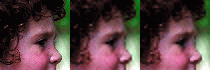

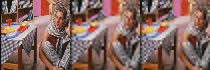

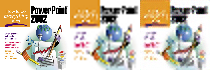

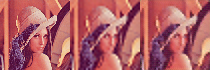

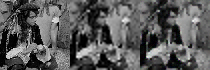

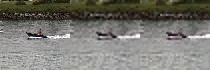

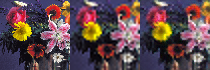

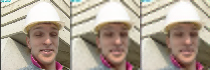

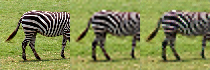

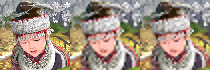

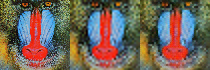

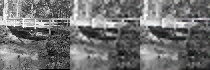

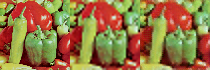

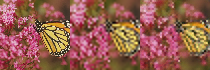

SSIM
max: [7] 0.88    min: [8] 0.59    avg: 0.70
TOTAL_VARIATION
max: [9] 1985.79    min: [0] 809.44    avg: 1508.82
PSNR
max: [0] 27.44    min: [2] 15.90    avg: 20.68
MEAN_SQUARED_ERROR
max: [2] 126.08    min: [0] 8.83    avg: 50.61
MEAN_ABSOLUTE_ERROR
max: [8] 438.54    min: [0] 141.28    avg: 316.72


In [0]:
from google.colab.patches import cv2_imshow

ds_ev_lr = DirectoryDataset("set14_70_70_color")\
    .map(downsample)\
    .map(normalize)
ds_ev_hr = DirectoryDataset("set14_70_70_color")\
    .map(normalize)

# load best network state
network.load_state("_color")

with ds_ev_lr as x, ds_ev_hr as y:
    x_batch = next(iter(x))
    y_batch = next(iter(y))
    # predict
    y_pred = network.predict(x_batch)
    print("   HR   ALIASED   NETWORK   ")
    for image_idx in range(len(x_batch)):
        aliased = tf.image.resize(x_batch[image_idx], size=tuple(y_batch[image_idx].shape[:2]), method="bicubic", antialias=True)
        img_0 = np.concatenate((y_batch[image_idx], aliased, y_pred[image_idx]), axis=1)
        cv2_imshow(img_0*255)
    # evaluate
    results = network.evaluate(y_batch, y_pred)

[2020-05-19 19:28:20,335] INFO _parse_predict_optionals(): Predicting using the default upsampling factor of 2.
[2020-05-19 19:28:21,944] INFO _predict(): Predicted images with shape: (10, 70, 70, 3)
   HR   ALIASED   NETWORK   


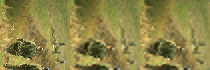

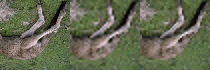

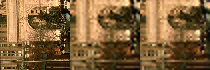

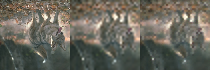

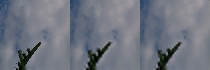

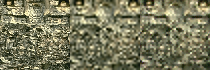

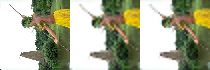

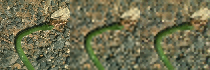

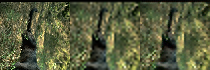

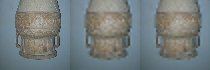

SSIM
max: [4] 0.96    min: [5] 0.56    avg: 0.71
TOTAL_VARIATION
max: [5] 2261.78    min: [4] 364.57    avg: 1134.89
PSNR
max: [4] 32.57    min: [5] 16.25    avg: 23.46
MEAN_SQUARED_ERROR
max: [5] 116.30    min: [4] 2.71    avg: 34.62
MEAN_ABSOLUTE_ERROR
max: [5] 584.76    min: [4] 43.84    avg: 257.87


In [0]:
# PREDICT WITH THE TRAINING DATASET - TRANSFORMED

ds = HDFDataset("bsd500_70_70_color.h5").batch(10).transform()
ds_hr = ds.map(normalize)
ds_lr = ds.map(downsample).map(normalize)

with ds_lr.batch(10) as x, ds_hr.batch(10) as y:
    x_batch = next(iter(x))
    y_batch = next(iter(y))
    # predict
    y_pred = network.predict(x_batch)
    print("   HR   ALIASED   NETWORK   ")
    for image_idx in range(len(x_batch)):
        aliased = tf.image.resize(x_batch[image_idx], size=tuple(y_batch[image_idx].shape[:2]), method="bicubic", antialias=True)
        img_0 = np.concatenate((y_batch[image_idx], aliased, y_pred[image_idx]), axis=1)
        cv2_imshow(img_0*255)
    # evaluate
    results = network.evaluate(y_batch, y_pred)

[2020-05-19 19:28:22,262] INFO _parse_predict_optionals(): Predicting using the default upsampling factor of 2.
[2020-05-19 19:28:22,267] INFO _predict(): Predicted images with shape: (10, 70, 70, 3)
   HR   ALIASED   NETWORK   


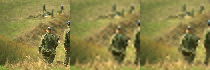

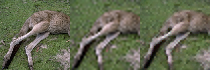

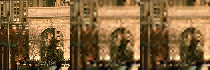

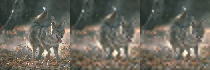

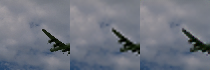

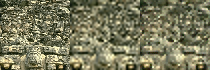

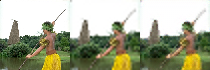

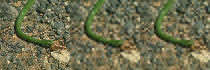

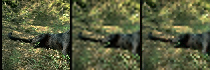

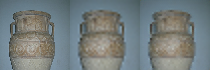

SSIM
max: [4] 0.96    min: [5] 0.56    avg: 0.71
TOTAL_VARIATION
max: [5] 2243.00    min: [4] 366.53    avg: 1133.55
PSNR
max: [4] 32.65    min: [5] 16.25    avg: 23.49
MEAN_SQUARED_ERROR
max: [5] 116.20    min: [4] 2.66    avg: 34.53
MEAN_ABSOLUTE_ERROR
max: [5] 585.14    min: [4] 43.84    avg: 257.62


In [0]:
# PREDICT WITH THE TRAINING DATASET - NON-TRANSFORMED

ds = HDFDataset("bsd500_70_70_color.h5").batch(10)
ds_hr = ds.map(normalize)
ds_lr = ds.map(downsample).map(normalize)

with ds_lr.batch(10) as x, ds_hr.batch(10) as y:
    x_batch = next(iter(x))
    y_batch = next(iter(y))
    # predict
    y_pred = network.predict(x_batch)
    print("   HR   ALIASED   NETWORK   ")
    for image_idx in range(len(x_batch)):
        aliased = tf.image.resize(x_batch[image_idx], size=tuple(y_batch[image_idx].shape[:2]), method="bicubic", antialias=True)
        img_0 = np.concatenate((y_batch[image_idx], aliased, y_pred[image_idx]), axis=1)
        cv2_imshow(img_0*255)
    # evaluate
    results = network.evaluate(y_batch, y_pred)

In [0]:
!zip -r ./progressiveupsamplingnetwork_color.zip ./checkpoints/progressiveupsamplingnetwork_color

  adding: checkpoints/progressiveupsamplingnetwork_color/ (stored 0%)
  adding: checkpoints/progressiveupsamplingnetwork_color/checkpoint (deflated 37%)
  adding: checkpoints/progressiveupsamplingnetwork_color/weights.data-00001-of-00002 (deflated 8%)
  adding: checkpoints/progressiveupsamplingnetwork_color/state.dat (deflated 15%)
  adding: checkpoints/progressiveupsamplingnetwork_color/weights.data-00000-of-00002 (deflated 73%)
  adding: checkpoints/progressiveupsamplingnetwork_color/weights.index (deflated 61%)


In [0]:
from google.colab.files import download

download("progressiveupsamplingnetwork_color.zip")